In [ ]:
# Notebook used to test nCAFQA with PT.

# CAFQA

In [1]:
import sys
sys.path.append("../")
from clapton.clapton import claptonize
from clapton.ansatzes import circular_ansatz,circular_ansatz_mirrored
from clapton.evaluation import get_energy
import numpy as np
from numbers import Number

In [2]:
def ising_model(N, Jx, h, Jy=0., periodic=False):
    """
    Constructs qubit Hamiltonian for linear Ising model.
    H = sum_{i=0...N-2} (Jx_i X_i X_{i+1} + Jy_i Y_i Y_{i+1}) + sum_{i=0...N-1}  h_i Z_i

    N (Int): # sites/qubits.
    Jx (Float, Iterable[Float]): XX strength, either constant value or list (values for each pair of neighboring sites).
    h (Float, Iterable[Float]): Z self-energy, either constant value or list (values for each site).
    Jy (Float, Iterable[Float]): YY strength, either constant value or list (values for each pair of neighboring sites).
    periodic: If periodic boundary conditions. If True, include term X_0 X_{N-1} and Y_0 Y_{N-1}.

    Returns:
    (Iterable[Float], Iterable[String], String) (Pauli coefficients, Pauli strings, "0"*N)
    """
    if isinstance(Jx, Number):
        if periodic:
            Jx = [Jx] * N
        else:
            Jx = [Jx] * (N-1)
    if isinstance(Jy, Number):
        if periodic:
            Jy = [Jy] * N
        else:
            Jy = [Jy] * (N-1)
    if isinstance(h, Number):
        h = [h] * N        
    if N > 1:
        assert len(Jx) == N if periodic else len(Jx) == N-1, "Jx has wrong length"
        assert len(Jy) == N if periodic else len(Jy) == N-1, "Jy has wrong length"
        assert len(h) == N, "h has wrong length"
    coeffs = []
    paulis = []
    # add XX terms
    for j in range(N-1):
        if np.abs(Jx[j]) > 1e-12:
            coeffs.append(Jx[j])
            paulis.append("I"*j+"XX"+"I"*(N-j-2))
    if N > 2 and periodic and np.abs(Jx[N-1]) > 1e-12:
        coeffs.append(Jx[N-1])
        paulis.append("X"+"I"*(N-2)+"X")
    # add YY terms
    for j in range(N-1):
        if np.abs(Jy[j]) > 1e-12:
            coeffs.append(Jy[j])
            paulis.append("I"*j+"YY"+"I"*(N-j-2))
    if N > 2 and periodic and np.abs(Jy[N-1]) > 1e-12:
        coeffs.append(Jy[N-1])
        paulis.append("Y"+"I"*(N-2)+"Y")
    # add Z terms
    for j in range(N):
        if np.abs(h[j]) > 1e-12:
            coeffs.append(h[j])
            paulis.append("I"*j+"Z"+"I"*(N-j-1))
    return coeffs, paulis, "1"*N

In [3]:
# set seed for reproducibility
np.random.seed(42)

# # define Hamiltonian, e.g. 3q Heisenberg model with random coefficients
# paulis = ["XXI", "IXX", "YYI", "IYY", "ZZI", "IZZ"]
# coeffs = np.random.random(len(paulis))
# paulis, coeffs

# Multi Qubit Hamiltonian
num_qubits = 2
coeffs,paulis,_ = ising_model(N=num_qubits,Jx=0.2,Jy=0.3,h=0.4)

In [4]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_algorithms import NumPyMinimumEigensolver

weights  =  coeffs
pauli_op = [([pauli,weight]) for pauli,weight in zip(paulis,weights)]
hamiltonian = SparsePauliOp.from_list([ op for op in pauli_op ])

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=hamiltonian)
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -0.80623


In [5]:
# define parametrized Clifford circuit that is being optimized over
# here we use the circular_ansatz template
# we fix 2q gates as they will not be optimized over
reps = 1
vqe_pcirc = circular_ansatz(N=num_qubits, reps=reps, fix_2q=True)

In [6]:
# the circuit consists of parametrized gates
for gate in vqe_pcirc.gates:
    print(gate.label, gate.is_fixed())

RY False
RY False
RZ False
RZ False
2Q True
2Q True
RY False
RY False
RZ False
RZ False


In [7]:
# non-fixed gates will be optimized over
# RY and RZ gates can assume 4 values k = 0,1,2,3 which describe multiples of pi/2

In [8]:
# the initial parameters are all 0
vqe_pcirc.read()

[0, 0, 0, 0, 0, 0, 0, 0]

In [9]:
# we can look at the corresponding stim circuit
vqe_pcirc.stim_circuit().diagram()

q0: -I-I-X-@-I-I-
         | |
q1: -I-I-@-X-I-I-

In [10]:
# we can assign a different set of parameters
# vqe_pcirc.assign([0,1,2,3,0,1,2,3,0,1,2,3])

In [11]:
vqe_pcirc.stim_circuit().diagram()

q0: -I-I-X-@-I-I-
         | |
q1: -I-I-@-X-I-I-

In [12]:
# we can perform CAFQA by using the main optimization function "claptonize"
ks_best, _, energy_best = claptonize(
    paulis,
    coeffs,
    vqe_pcirc,
    n_proc=4,           # total number of processes in parallel
    n_starts=4,         # number of random genetic algorithm starts in parallel
    n_rounds=1,         # number of budget rounds, if None it will terminate itself
    callback=print,     # callback for internal parameter (#iteration, energies, ks) processing
    budget=20           # budget per genetic algorithm instance
)

STARTING ROUND 0


started GA at id 1 with 1 procs

started GA at id 2 with 1 procs



/home/dbharadwaj/anaconda3/envs/clapton/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


started GA at id None with 1 procs


started GA at id 3 with 1 procs


/home/dbharadwaj/anaconda3/envs/clapton/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/dbharadwaj/anaconda3/envs/clapton/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evo

[0, array([0., 0., 0., 0.]), array([3, 3, 0, 2, 3, 3, 2, 3], dtype=object)]
[0, array([0., 0., 0., 0.]), array([3, 3, 0, 2, 3, 3, 2, 3], dtype=object)]
[0, array([0., 0., 0., 0.]), array([3, 3, 0, 2, 3, 3, 2, 3], dtype=object)]
[0, array([0., 0., 0., 0.]), array([3, 3, 0, 2, 3, 3, 2, 3], dtype=object)]
[1, array([0., 0., 0., 0.]), array([3, 1, 1, 3, 2, 1, 2, 3], dtype=object)]
[1, array([0., 0., 0., 0.]), array([3, 1, 1, 3, 2, 1, 2, 3], dtype=object)]
[1, array([0., 0., 0., 0.]), array([3, 1, 1, 3, 2, 1, 2, 3], dtype=object)][1, array([0., 0., 0., 0.]), array([3, 1, 1, 3, 2, 1, 2, 3], dtype=object)]

[2, array([0., 0., 0., 0.]), array([3, 1, 2, 3, 2, 1, 2, 3], dtype=object)]
[2, array([0., 0., 0., 0.]), array([3, 1, 2, 3, 2, 1, 2, 3], dtype=object)][2, array([0., 0., 0., 0.]), array([3, 1, 2, 3, 2, 1, 2, 3], dtype=object)][2, array([0., 0., 0., 0.]), array([3, 1, 2, 3, 2, 1, 2, 3], dtype=object)]


[3, array([0., 0., 0., 0.]), array([1, 1, 3, 2, 0, 0, 2, 1], dtype=object)]
[3, array([0

In [13]:
# the best parameters are
ks_best

[1, 0, 2, 0, 2, 1, 3, 1]

In [14]:
# with energy
energy_best 

0.0

In [15]:
# the corresponding circuit is
vqe_pcirc.assign(ks_best)
vqe_pcirc.stim_circuit().diagram()

q0: -SQRT_Y-Z-X-@-Y------S_DAG-
              | |
q1: -I------I-@-X-SQRT_Y-S-----

# noisy CAFQA (nCAFQA)

In [16]:
from clapton.depolarization import GateGeneralDepolarizationModel

In [17]:
# let's add a noise model where we specify global 1q and 2q gate errors
nm = GateGeneralDepolarizationModel(p1=0.005, p2=0.05) #NOTE: This is the Noise Model, not representative of device noise

In [18]:
vqe_pcirc = circular_ansatz(N=num_qubits, reps=reps, fix_2q=True)
vqe_pcirc.add_depolarization_model(nm)

In [19]:
# after every gate a depol channel is added
vqe_pcirc.stim_circuit().diagram()

q0: -I-DEPOLARIZE1(0.005)-I------------------DEPOLARIZE1(0.005)--------------------X-DEPOLARIZE2(0.05)-@-DEPOLARIZE2(0.05)-I-DEPOLARIZE1(0.005)-I------------------DEPOLARIZE1(0.005)--------------------
                                                                                   | |                 | |
q1: ---I------------------DEPOLARIZE1(0.005)-I------------------DEPOLARIZE1(0.005)-@-DEPOLARIZE2(0.05)-X-DEPOLARIZE2(0.05)---I------------------DEPOLARIZE1(0.005)-I------------------DEPOLARIZE1(0.005)-

In [20]:
# we can perform nCAFQA by using the main optimization function "claptonize"
# now with the noisy circuit
ks_best, energy_noisy, energy_noiseless = claptonize(
    paulis,
    coeffs,
    vqe_pcirc,
    n_proc=4,           # total number of processes in parallel
    n_starts=4,         # number of random genetic algorithm starts in parallel
    n_rounds=1,         # number of budget rounds, if None it will terminate itself
    callback=print,     # callback for internal parameter (#iteration, energies, ks) processing
    budget=20           # budget per genetic algorithm instance
)

STARTING ROUND 0


started GA at id 1 with 1 procs

started GA at id 2 with 1 procs


started GA at id None with 1 procs

started GA at id 3 with 1 procs
[0, array([-0.00712, -0.00712,  0.     ,  0.     ]), array([1, 2, 0, 2, 1, 3, 3, 0], dtype=object)]
[0, array([-0.00538, -0.00538,  0.     ,  0.     ]), array([3, 1, 1, 3, 1, 0, 3, 0], dtype=object)]
[0, array([-0.00892, -0.00892,  0.     ,  0.     ]), array([0, 3, 1, 2, 0, 3, 3, 0], dtype=object)]
[0, array([-0.0083, -0.0083,  0.    ,  0.    ]), array([2, 2, 3, 2, 3, 2, 1, 0], dtype=object)]
[1, array([-0.00842, -0.00842,  0.     ,  0.     ]), array([3, 0, 2, 1, 2, 1, 3, 1], dtype=object)]
[1, array([-0.00852, -0.00852,  0.     ,  0.     ]), array([0, 3, 2, 1, 2, 3, 3, 3], dtype=object)]
[1, array([-0.01028, -0.01028,  0.     ,  0.     ]), array([3, 3, 0, 0, 0, 1, 1, 0], dtype=object)]
[1, array([-0.00646, -0.00646,  0.     ,  0.     ]), array([1, 0, 3, 3, 2, 2, 3, 2], dtype=object)]
[2, array([-0.00508, -0.00508,  0.     ,  0.     ]

In [21]:
# the best parameters are
ks_best

[1, 3, 1, 2, 0, 3, 3, 0]

In [22]:
# with noisy/noiseless energy
energy_noisy, energy_noiseless

(0.008499999999999952, 0.0)

In [23]:
# the corresponding circuit is
vqe_pcirc.assign(ks_best)
vqe_pcirc.snapshot_noiseless().circ_snapshot_noiseless.diagram()

q0: -SQRT_Y-----S-X-@-I----------S_DAG-
                  | |
q1: -SQRT_Y_DAG-Z-@-X-SQRT_Y_DAG-I-----

## Let's do one VQE iteration now

In [24]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate,ParameterVector
from qiskit.circuit.library import CXGate, ECRGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator, pauli_basis
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeMumbaiV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError, coherent_unitary_error
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from typing import Iterable, Optional
from scipy.optimize import minimize

In [25]:
class PauliTwirl(TransformationPass):
    """Add Pauli twirls to two-qubit gates."""
 
    def __init__(
        self,
        gates_to_twirl: Optional[Iterable[Gate]] = None,
    ):
        """
        Args:
            gates_to_twirl: Names of gates to twirl. The default behavior is to twirl all
                two-qubit basis gates, `cx` and `ecr` for IBM backends.
        """
        if gates_to_twirl is None:
            gates_to_twirl = [CXGate(), ECRGate()]
        self.gates_to_twirl = gates_to_twirl
        self.build_twirl_set()
        super().__init__()
 
    def build_twirl_set(self):
        """
        Build a set of Paulis to twirl for each gate and store internally as .twirl_set.
        """
        self.twirl_set = {}
 
        # iterate through gates to be twirled
        for twirl_gate in self.gates_to_twirl:
            twirl_list = []
 
            # iterate through Paulis on left of gate to twirl
            for pauli_left in pauli_basis(2):
                # iterate through Paulis on right of gate to twirl
                for pauli_right in pauli_basis(2):
                    # save pairs that produce identical operation as gate to twirl
                    if (Operator(pauli_left) @ Operator(twirl_gate)).equiv(
                        Operator(twirl_gate) @ pauli_right
                    ):
                        twirl_list.append((pauli_left, pauli_right))
 
            self.twirl_set[twirl_gate.name] = twirl_list
 
    def run(
        self,
        dag: DAGCircuit,
    ) -> DAGCircuit:
        # collect all nodes in DAG and proceed if it is to be twirled
        twirling_gate_classes = tuple(
            gate.base_class for gate in self.gates_to_twirl
        )
        for node in dag.op_nodes():
            if not isinstance(node.op, twirling_gate_classes):
                continue
 
            # random integer to select Pauli twirl pair
            pauli_index = np.random.randint(
                0, len(self.twirl_set[node.op.name])
            )
            twirl_pair = self.twirl_set[node.op.name][pauli_index]
 
            # instantiate mini_dag and attach quantum register
            mini_dag = DAGCircuit()
            register = QuantumRegister(2)
            mini_dag.add_qreg(register)
 
            # apply left Pauli, gate to twirl, and right Pauli to empty mini-DAG
            mini_dag.apply_operation_back(
                twirl_pair[0].to_instruction(), [register[0], register[1]]
            )
            mini_dag.apply_operation_back(node.op, [register[0], register[1]])
            mini_dag.apply_operation_back(
                twirl_pair[1].to_instruction(), [register[0], register[1]]
            )
 
            # substitute gate to twirl node with twirling mini-DAG
            dag.substitute_node_with_dag(node, mini_dag)
 
        return dag

In [26]:
def qiskit_circular_ansatz(N, reps=1): 
    qc = QuantumCircuit(N)

    # define your parameters
    p = ParameterVector('p', (N*2) *(reps+1)) 

    for r in range(reps): 
        for i in range(N):
            qc.ry(p[2*N*r+i], i)  
        for i in range(N):
            qc.rz(p[2*N*r+(i+N)], i)
        for i in range(N):
            control = (i-1) % N
            target = i
            qc.cx(control, target)
    for i in range(N):
        qc.ry(p[2*N*reps+i], i)
    for i in range(N):
        qc.rz(p[2*N*reps + (i+N)], i)
    return qc

qc = qiskit_circular_ansatz(num_qubits,reps)

In [27]:
# np.random.seed(0)
# paulis = ["".join(np.random.choice(['I', 'X', 'Y', 'Z'], size=num_qubits)) for _ in range(num_qubits)]
# coeffs = np.random.random(len(paulis))
# hamiltonian = SparsePauliOp.from_list(list(zip(paulis, coeffs)))

In [28]:
# Set initial parameters
# initial_params = np.zeros(qc.num_parameters)
initial_params = ks_best
initial_params

[1, 3, 1, 2, 0, 3, 3, 0]

In [29]:
# Calculate Exact Ground State Energy
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
ref_result = numpy_solver.compute_minimum_eigenvalue(operator=hamiltonian)
ref_value = ref_result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}") #NOTE: Check if both reference values match

Reference value: -0.80623


In [30]:
# Create your custom pass
pm = PassManager([PauliTwirl()])

#Create your twirled circuits
twirled_qcs = [pm.run(qc) for _ in range(1)]

In [31]:
# Device Noise Model
backend = FakeMumbaiV2() # Your quantum backend
noise_model = NoiseModel.from_backend(backend) 

In [ ]:
# # Only Coherent Noise Model 
# noise_model = NoiseModel()

# # Define the over-rotation angle (in radians)
# theta = 0.1  # Adjust this value to control the amount of over-rotation

# # Create the over-rotated CX gate
# cx_overrotated = Operator([
#     [np.cos(theta/2), -1j*np.sin(theta/2), 0, 0],
#     [-1j*np.sin(theta/2), np.cos(theta/2), 0, 0],
#     [0, 0, np.cos(theta/2), -1j*np.sin(theta/2)],
#     [0, 0, -1j*np.sin(theta/2), np.cos(theta/2)]
# ])

# # Create a quantum error from the over-rotated CX gate
# noise_model.add_all_qubit_quantum_error(coherent_unitary_error(cx_overrotated), ['cx'])
# print(noise_model)

In [33]:
pt_vqe_energies=[]
iteration_number=0
def pt_vqe_cost_function(params, ansatz, hamiltonian, pass_manager, estimator,twirled_qcs):
    global iteration_number 
    # Bind parameters to the ansatz
    # bound_circuit = ansatz.assign_parameters(params)
    
    #Apply the pass manager
    # twirled_qcs = [pass_manager.run(bound_circuit) for _ in range(100)]

    # Calculate expectation value
    energy_values = np.array([])
    for transpiled_circuit in twirled_qcs:
        transpiled_circuit = transpiled_circuit.assign_parameters(params)
        job = estimator.run([(transpiled_circuit, hamiltonian)]) #Something wrong w parameter optim.
        result = job.result()
        energy = result[0].data.evs #NOTE: Is this actually expectation value?
        energy_values = np.append(energy_values, energy)
    
    iteration_number += 1
    # Print statement to see where we are at
    print(f"Iteration: {iteration_number}, Current energy: {np.average(energy_values)}, Current parameters: {params}")
    # return result.values[0]
    pt_vqe_energies.append(np.average(energy_values))
    return np.average(energy_values)

# # Create an Estimator instance

##Noisy
# estimator = Estimator(
#     mode=AerSimulator(
#         noise_model=noise_model,
#         coupling_map=backend.coupling_map,
#         basis_gates=noise_model.basis_gates,
#         device = 'GPU'
#     )
# )

# # # Create an Estimator instance

estimator = Estimator(mode=AerSimulator(method='statevector',device = "GPU"))

In [34]:
result = minimize(
    pt_vqe_cost_function,
    initial_params,
    args=(qc, hamiltonian, pm, estimator,twirled_qcs),
    method='COBYLA',
    options={'maxiter': 100}
)

pt_optimal_params = result.x
pt_optimal_value = result.fun

print(f"Optimal value: {pt_optimal_value}")
print(f"Optimal parameters: {pt_optimal_params}")

Iteration: 1, Current energy: -0.46611328125, Current parameters: [1. 3. 1. 2. 0. 3. 3. 0.]
Iteration: 2, Current energy: 0.29453125, Current parameters: [2. 3. 1. 2. 0. 3. 3. 0.]
Iteration: 3, Current energy: -0.33916015625, Current parameters: [1. 4. 1. 2. 0. 3. 3. 0.]
Iteration: 4, Current energy: -0.39697265625, Current parameters: [1. 3. 2. 2. 0. 3. 3. 0.]
Iteration: 5, Current energy: -0.47050781250000007, Current parameters: [1. 3. 1. 3. 0. 3. 3. 0.]
Iteration: 6, Current energy: -0.35668945312499994, Current parameters: [1. 3. 1. 3. 1. 3. 3. 0.]
Iteration: 7, Current energy: -0.44526367187500004, Current parameters: [1. 3. 1. 3. 0. 4. 3. 0.]
Iteration: 8, Current energy: -0.5001953125, Current parameters: [1. 3. 1. 3. 0. 3. 4. 0.]
Iteration: 9, Current energy: -0.483203125, Current parameters: [1. 3. 1. 3. 0. 3. 4. 1.]
Iteration: 10, Current energy: -0.79150390625, Current parameters: [ 0.02947659  2.83801766  0.91178193  3.00560708 -0.1452234   2.96779043
  4.03787895 -0.02168

In [35]:
iteration_number= 0

vqe_energies = []
def vqe_cost_function(params, ansatz, hamiltonian, pass_manager, estimator):
    global iteration_number 
    # Bind parameters to the ansatz
    bound_circuit = ansatz.assign_parameters(params)
    
    # Calculate expectation value
    job = estimator.run([(bound_circuit, hamiltonian)]) #Something wrong w parameter optim.
    result = job.result()
    energy = result[0].data.evs 
    vqe_energies.append(energy)
    
    iteration_number += 1
    # Print statement to see where we are at
    print(f"Iteration: {iteration_number}, Current energy: {energy}, Current parameters: {params}")
    return energy

In [36]:
result = minimize(
    vqe_cost_function,
    initial_params,
    args=(qc, hamiltonian, pm, estimator),
    method='COBYLA',
    options={'maxiter': 100}
)

optimal_params = result.x
optimal_value = result.fun

print(f"Optimal value without PT : {optimal_value}")
print(f"Optimal parameters: {optimal_params}")

Iteration: 1, Current energy: -0.43940429687500004, Current parameters: [1. 3. 1. 2. 0. 3. 3. 0.]
Iteration: 2, Current energy: 0.27944335937500003, Current parameters: [2. 3. 1. 2. 0. 3. 3. 0.]
Iteration: 3, Current energy: -0.353564453125, Current parameters: [1. 4. 1. 2. 0. 3. 3. 0.]
Iteration: 4, Current energy: -0.38017578125, Current parameters: [1. 3. 2. 2. 0. 3. 3. 0.]
Iteration: 5, Current energy: -0.463916015625, Current parameters: [1. 3. 1. 3. 0. 3. 3. 0.]
Iteration: 6, Current energy: -0.35317382812500003, Current parameters: [1. 3. 1. 3. 1. 3. 3. 0.]
Iteration: 7, Current energy: -0.431640625, Current parameters: [1. 3. 1. 3. 0. 4. 3. 0.]
Iteration: 8, Current energy: -0.51611328125, Current parameters: [1. 3. 1. 3. 0. 3. 4. 0.]
Iteration: 9, Current energy: -0.47734375, Current parameters: [1. 3. 1. 3. 0. 3. 4. 1.]
Iteration: 10, Current energy: -0.7833496093750001, Current parameters: [ 0.02694135  2.88380403  0.9198261   3.03317996 -0.1499047   2.95631084
  4.07065614 

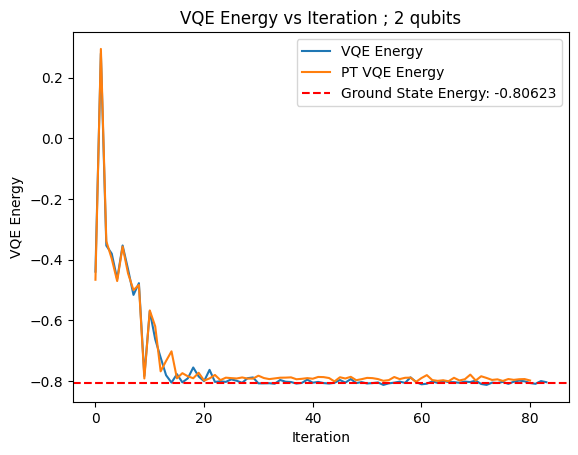

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

plt.plot(vqe_energies, label='VQE Energy')
plt.plot(pt_vqe_energies, label='PT VQE Energy')
plt.axhline(y=ref_value, color='r', linestyle='--', label=f'Ground State Energy: {ref_value:.5f}')
plt.xlabel('Iteration')
plt.ylabel('VQE Energy')
plt.title(f'VQE Energy vs Iteration ; {num_qubits} qubits')
plt.legend()
plt.show()
# nm = None
import matplotlib
matplotlib.use('Agg')  # Non-interactive backends